<a href="https://colab.research.google.com/github/Nickmyt/nums_dataset/blob/main/Sound.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

import librosa as lib
import librosa.display
from sklearn import preprocessing
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import wavio as wv
from scipy.io.wavfile import write
import matplotlib.pyplot as plt
import noisereduce as nr
from sklearn.datasets import fetch_species_distributions
from sklearn.model_selection import train_test_split
from keras.layers import LSTM, Dense, SimpleRNN , Dropout
from keras.models import Sequential
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder

In [ ]:
!git clone https://github.com/Nickmyt/nums_dataset
!pip install wavio
!pip install noisereduce

Cloning into 'nums_dataset'...
remote: Enumerating objects: 23505, done.
remote: Total 23505 (delta 0), reused 0 (delta 0), pack-reused 23505
Receiving objects: 100% (23505/23505), 508.79 MiB | 17.35 MiB/s, done.
Resolving deltas: 100% (44/44), done.
Checking out files: 100% (23666/23666), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
def convert_to_mel(signal, sample_rate):
    print("-----Getting the mel spectrogramms for the original and processed signal-----")
    
    plt.figure(figsize=(14, 5))
    #Caclulate the Short time Fourier transform
   # sgram = librosa.stft(signal)
    #Converting to mel scale instead of frequancy
    #sgram_mag, _ = librosa.magphase(sgram)
    
    mel_scale_sgram = lib.feature.melspectrogram(y=sgram_mag,n_mels = 128*2, sr=sample_rate)
    #cConvert to  db scale for final mel spectogram
    mel_sgram = lib.amplitude_to_db(mel_scale_sgram, ref=np.max)
    print(mel_sgram.shape)
    #Display the mel-spectrogram
    librosa.display.specshow(mel_sgram, sr=sample_rate, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Spectrogram')
    plt.show()
    return mel_sgram

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


(184662,)
(182614,)
-----Getting the mel spectrogramms for the original and processed signal-----


ParameterError: ignored

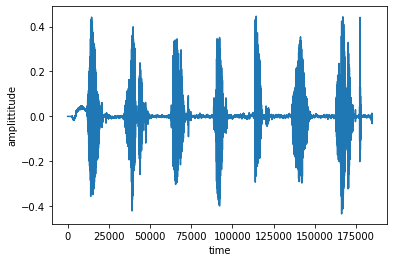

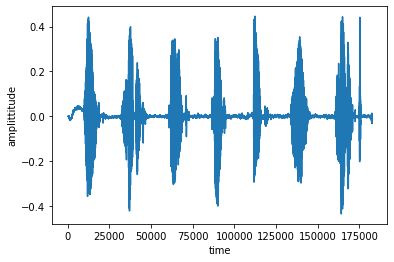

<Figure size 1008x360 with 0 Axes>

In [ ]:
    
  #Load the recording
signal, _ = lib.load('/content/drive/MyDrive/recording1.wav',sr = 16000)
print(signal.shape)
plt.figure()
plt.plot(signal)
plt.xlabel("time")
plt.ylabel("amplittitude")
plt.plot()
plt.show

processed_signal = lib.effects.preemphasis(signal)
 

processed_signal =  nr.reduce_noise(processed_signal,sr=16000)

processed_signal, _ = lib.effects.trim(signal, 40)
    #----Next step remove noise from signal
    #----Noise reduce library has the reduce noice function

  
    #a---Now we must keep the important information
    #----To do that we remove the parts that are below 40db because they provide zero information

plt.figure()
plt.plot(processed_signal)
plt.xlabel("time")
plt.ylabel("amplittitude")
plt.plot()
plt.show 
print(processed_signal.shape)    
    #----Now to get the plots for the original signal and the processed one
spectrogram =convert_to_mel(processed_signal, sample_rate = 16000)


In [ ]:
    #----Since the sample rate is 16000  and the window time is 30 ms the hop time is 16000*0.03 = 480 
hop = int(16000 * 0.03)
window_frames = lib.onset.onset_detect(processed_signal,sr=16000,hop_length=hop)
window_Shifting_Time = lib.frames_to_time(window_frames,sr=16000,hop_length=hop)
    
segments = lib.frames_to_samples(window_frames,hop)
    
    #----Reverse the signal 
    #----After that we revert the window frames array and shifting time array
    
reversed_processed_signal = processed_signal[::-1]
    
window_frames_reversed = lib.onset.onset_detect(reversed_processed_signal, sr=16000, hop_length=hop)
shifting_time_reverse = lib.frames_to_time(window_frames_reversed,sr=16000, hop_length=hop)
    
Length_shifting_time_reverse = len(shifting_time_reverse) 
print(Length_shifting_time_reverse)
    
for i in range(0, Length_shifting_time_reverse - 1):
      shifting_time_reverse[i] =  0.03 - shifting_time_reverse[i]
      i +=1
    
shifting_time_reverse = sorted(shifting_time_reverse)
    
Length_shifting_time_reverse = len(shifting_time_reverse)
print(shifting_time_reverse)   
i = 0
while i < len(shifting_time_reverse) -1  :
        if shifting_time_reverse[i + 1] - shifting_time_reverse[i] < 1:
            shifting_time_reverse = np.delete(shifting_time_reverse,i)
            i -=1
        i+= 1
    
    #window_Shifting_Time_length = len(window_Shifting_Time)
k=0
    
while k < len(window_Shifting_Time) - 1:
        if window_Shifting_Time[i+1] - window_Shifting_Time[i] < 1:
            window_Shifting_Time, window_frames, segments = np.delete(window_Shifting_Time,i+1), np.delete(window_frames,i+1), np.delete(segments,i+1)
            k-=1
        k+=1
    
combined_shifting_times = [*window_Shifting_Time,*shifting_time_reverse]
    #----check if it works
segments = lib.time_to_samples((sorted(combined_shifting_times)),sr=16000)


19
[-10.5, -10.26, -9.15, -8.97, -8.67, -7.38, -5.52, -4.6499999999999995, -4.2, -3.9000000000000004, -2.8800000000000003, -2.4600000000000004, -2.3400000000000003, -1.05, -0.84, -0.75, -0.63, -0.42000000000000004, 11.07]


/usr/local/lib/python3.7/dist-packages/librosa/filters.py:239: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  "Empty filters detected in mel frequency basis. "


In [ ]:
 #----Initiate array of numbers found
nums = {}
     #----Get length of the segments array
segment_size = len(segments)
     #----Count how many numbers we found
counter=0
for i in range(0,segment_size,2):
         #----Check segment size 
         if i == segment_size- 1 and segment_size %2 == 1  :  
             nums[counter] = (processed_signal[segments[i-1]:segments[i]])
         else:
             nums[counter] = (processed_signal[segments[i]:segments[i+1]])
         counter+=1    
print(nums[0].shape)
print(nums[1].shape)            

(25440,)
(55680,)


In [ ]:
numbers = ['zero','one','two','three','four','five','six','seven','eight','nine']
labels = ['0','1','2','3','4','5','6','7','8','9']
file_path = "/content/nums_dataset/"
NN_data = []
y= []
index = 0

for num in numbers:
        
        number_path = file_path + num
        
        for file in os.listdir(number_path):
            audiofile  = os.path.join(number_path , file)
            
            audio , _ = lib.load(audiofile, sr = 16000)
            if len(audio) == 16000:
              y.append(num)
              
              sgram = lib.stft(audio)
      #Converting to mel scale instead of frequancy
              sgram_mag, _ = lib.magphase(sgram)
      
              mel_scale_sgram = lib.feature.melspectrogram(S=sgram_mag, sr=16000)
              
        #cConvert to  db scale for final mel spectogram
              mel_sgram = lib.amplitude_to_db(mel_scale_sgram, ref=np.min)
              
              shape = mel_sgram.shape
              print(shape)
              padded_array = np.zeros((128, 150))

              padded_array[:shape[0],:shape[1]] = mel_sgram
  
              NN_data.append(padded_array)
              
            
        index+=1
            
    

 
    #for i in NN_data:
    #    shape = np.shape(i)
    #    array_padded = np.zeros((128,36))
    #    array_padded[:shape[0],shape[1]] = i[0]
    #    i[0] = array_padded
        


     
        

Η έξοδος ροής περικόπηκε στις τελευταίες 5000 γραμμές.
(128, 32)
(128, 32)
(128, 32)
(128, 32)
(128, 32)
(128, 32)
(128, 32)
(128, 32)
(128, 32)
(128, 32)
(128, 32)
(128, 32)
(128, 32)
(128, 32)
(128, 32)
(128, 32)
(128, 32)
(128, 32)
(128, 32)
(128, 32)
(128, 32)
(128, 32)
(128, 32)
(128, 32)
(128, 32)
(128, 32)
(128, 32)
(128, 32)
(128, 32)
(128, 32)
(128, 32)
(128, 32)
(128, 32)
(128, 32)
(128, 32)
(128, 32)
(128, 32)
(128, 32)
(128, 32)
(128, 32)
(128, 32)
(128, 32)
(128, 32)
(128, 32)
(128, 32)
(128, 32)
(128, 32)
(128, 32)
(128, 32)
(128, 32)
(128, 32)
(128, 32)
(128, 32)
(128, 32)
(128, 32)
(128, 32)
(128, 32)
(128, 32)
(128, 32)
(128, 32)
(128, 32)
(128, 32)
(128, 32)
(128, 32)
(128, 32)
(128, 32)
(128, 32)
(128, 32)
(128, 32)
(128, 32)
(128, 32)
(128, 32)
(128, 32)
(128, 32)
(128, 32)
(128, 32)
(128, 32)
(128, 32)
(128, 32)
(128, 32)
(128, 32)
(128, 32)
(128, 32)
(128, 32)
(128, 32)
(128, 32)
(128, 32)
(128, 32)
(128, 32)
(128, 32)
(128, 32)
(128, 32)
(128, 32)
(128, 32)
(128,

In [ ]:
hop = 480
n_fft = 225
input_shape=(128,150)
model = Sequential()
model.add(LSTM(128,input_shape=input_shape))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(48, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(10, activation='softmax'))
model.summary()
    


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               142848    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 128)               16512     
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 48)                3120      
                                                                 
 dropout_2 (Dropout)         (None, 48)                0

In [ ]:
Numbers_found = []
NN_data = np.array(NN_data)
Y=y
print(y)
le = LabelEncoder()
Y=le.fit_transform(Y)
classes= list(le.classes_)
y=np_utils.to_categorical(Y, num_classes=10, dtype='float32')  
train_x,test_x,train_y,test_y = train_test_split(NN_data,y,test_size = 0.2)    
  
train_x = np.array(train_x)
test_x = np.array(test_x)

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=['accuracy'])
Epochs = 40
history = model.fit(train_x,train_y,batch_size = 32 ,epochs = Epochs, validation_data=(test_x,test_y))







            
        

['zero', 'zero', 'zero', 'zero', 'zero', 'zero', 'zero', 'zero', 'zero', 'zero', 'zero', 'zero', 'zero', 'zero', 'zero', 'zero', 'zero', 'zero', 'zero', 'zero', 'zero', 'zero', 'zero', 'zero', 'zero', 'zero', 'zero', 'zero', 'zero', 'zero', 'zero', 'zero', 'zero', 'zero', 'zero', 'zero', 'zero', 'zero', 'zero', 'zero', 'zero', 'zero', 'zero', 'zero', 'zero', 'zero', 'zero', 'zero', 'zero', 'zero', 'zero', 'zero', 'zero', 'zero', 'zero', 'zero', 'zero', 'zero', 'zero', 'zero', 'zero', 'zero', 'zero', 'zero', 'zero', 'zero', 'zero', 'zero', 'zero', 'zero', 'zero', 'zero', 'zero', 'zero', 'zero', 'zero', 'zero', 'zero', 'zero', 'zero', 'zero', 'zero', 'zero', 'zero', 'zero', 'zero', 'zero', 'zero', 'zero', 'zero', 'zero', 'zero', 'zero', 'zero', 'zero', 'zero', 'zero', 'zero', 'zero', 'zero', 'zero', 'zero', 'zero', 'zero', 'zero', 'zero', 'zero', 'zero', 'zero', 'zero', 'zero', 'zero', 'zero', 'zero', 'zero', 'zero', 'zero', 'zero', 'zero', 'zero', 'zero', 'zero', 'zero', 'zero', 'zero',

In [ ]:
for i in nums:
  print(nums[i].size)
for digit in nums:
  S = librosa.feature.melspectrogram(y=nums[digit], sr= 16000)
  S_db_mel = librosa.amplitude_to_db(S, ref= np.max)
  
  S_db_mel = np.expand_dims(S_db_mel, axis=0)
  [print(S_db_mel.shape)]

25440
55680
30720
4800
22080
4320
26880
7200
2400
15360
4320
2400
960
(1, 128, 50)
(1, 128, 109)
(1, 128, 61)
(1, 128, 10)
(1, 128, 44)
(1, 128, 9)
(1, 128, 53)
(1, 128, 15)
(1, 128, 5)
(1, 128, 31)
(1, 128, 9)
(1, 128, 5)
(1, 128, 2)


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=960
  n_fft, y.shape[-1]


In [ ]:
from numpy.lib.index_tricks import s_
def predict(audio):
    prob=model.predict(audio)
    index=np.argmax(prob[0])
    return classes[index]
  
index = 0  
for digit in nums: 
  dig = nums[digit]
  
  if nums[index].size != 0:
    S = librosa.feature.melspectrogram(y=nums[index], sr= 16000)
    S_db_mel = librosa.amplitude_to_db(S, ref= np.max)
    

    
    S_db_mel = np.expand_dims(S_db_mel, axis=0)
    shape = S_db_mel.shape
    padded_array = np.zeros((1, 128, 150))
    padded_array[:shape[0],:shape[1], :shape[2]] = S_db_mel

    

  
    print(predict(padded_array))
  index+=1

eight
six
eight
two
six
zero
two
seven
two
six
zero
eight
eight


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=960
  n_fft, y.shape[-1]


In [ ]:
for num in nums:
        #----For problems regarding speech recognition it is better to work with MFCC
        mel_coefficents = []
        
        number_mel = lib.feature.mfcc(y=num,S=processed_signal,sr=16000,hop_length = 480,n_mfcc=13)
        mel_magnitute_num = lib.amplitude_to_db(number_mel) 
        
        training_data_size = len(training_data)
        #----Initiate the cost array
        cost_array = []
        for i in range(0,training_data_size):
            #----filter all the training data
            filtered_data = lib.effects.trim(nr.reduce_noise(training_data[i],training_data[i]),40)
            training_data[i] = filtered_data
            
            #----Get the mfcc for each number and covert to db scale
            mfcc_db = lib.amplitude_to_db(lib.feature.mfcc(y=training_data[i],S=processed_signal,sr=16000,hop_length = 80,n_mfcc=13))
            mel_coefficents.append(mfcc_db)
                        
            cost, wp = lib.sequence.dtw(X=mel_magnitute_num,Y=mfcc_db)
            cost_array.append(cost[-1,-1])
        minimum_cost   =  cost_array.index(min(cost_array))
        Numbers_found.append(labels[minimum_cost])